
The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise. 

We'll drop the 'Time'.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

We create a baseline model of a Random Forest Classifier Model so that we can compare this result with the use of data resampling.
We will explore using 3 methods to see whether the model can be improved or not.

- Undersampling the Majority
- Oversampling the Minority
- Synthetic Minority Over-Sampling Technique (SMOTE)

### Import Relevant Libraries

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import findspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, DoubleType, StringType, IntegerType
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

from sklearn.metrics import confusion_matrix

### Initialize the Spark Context

In [52]:
# Use findspark.init() to locate spark on the system and import the library for you.
# If you don't do this step, you might face an issue of python worker failed to connect.
findspark.init()

# Start the Spark session
spark = SparkSession.builder.appName("creditcard").getOrCreate()

### Read creditcard.csv

In [53]:
newDF=[StructField('Time',IntegerType(),True),
       StructField('V1',DoubleType(),True),
       StructField('V2',DoubleType(),True),
       StructField('V3',DoubleType(),True),
       StructField('V4',DoubleType(),True),
       StructField('V5',DoubleType(),True),
       StructField('V6',DoubleType(),True),
       StructField('V7',DoubleType(),True),
       StructField('V8',DoubleType(),True),
       StructField('V9',DoubleType(),True),
       StructField('V10',DoubleType(),True),
       StructField('V11',DoubleType(),True),
       StructField('V12',DoubleType(),True),
       StructField('V13',DoubleType(),True),
       StructField('V14',DoubleType(),True),
       StructField('V15',DoubleType(),True),
       StructField('V16',DoubleType(),True),
       StructField('V17',DoubleType(),True),
       StructField('V18',DoubleType(),True),
       StructField('V19',DoubleType(),True),
       StructField('V20',DoubleType(),True),
       StructField('V21',DoubleType(),True),
       StructField('V22',DoubleType(),True),
       StructField('V23',DoubleType(),True),
       StructField('V24',DoubleType(),True),
       StructField('V25',DoubleType(),True),
       StructField('V26',DoubleType(),True),
       StructField('V27',DoubleType(),True),
       StructField('V28',DoubleType(),True),
       StructField('Amount',DoubleType(),True),
       StructField('Class',IntegerType(),True) 
       ]
finalStruct=StructType(fields=newDF)

pyspark_df = spark.read.format('csv')\
                    .option('header',True)\
                    .schema(finalStruct)\
                    .load('creditcard.csv')
pyspark_df.printSchema()

root
 |-- Time: integer (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (null

In [54]:
pyspark_df=pyspark_df.drop("Time")

In [55]:
pyspark_df.filter(F.col('Class')==1).count()


492

In [56]:
pyspark_df.filter(F.col('Class')==0).count()

284315

#### Create a table to store the results

In [57]:
from prettytable import PrettyTable 
# Specify the Column Names while initializing the Table 
resultsTable = PrettyTable(["Method", "AUROC", "Recall", "Accuracy","TN","TP","FP","FN"]) 

#### Split the data into train and test

In [58]:
# Set the train/test ratio
train_test_ratio = 0.8

# Split the data into training and testing sets using stratified sampling
train_data_class_b = pyspark_df.filter(F.col('Class')==1).sample(fraction=train_test_ratio, seed=88)
train_data_class_a = pyspark_df.filter(F.col('Class')==0).sample(fraction=train_test_ratio, seed=88)
train_data = train_data_class_a.union(train_data_class_b)

test_data = pyspark_df.subtract(train_data)

# Print the number of samples in each set
print("Training Set Size:", train_data.count())
print("Testing Set Size:", test_data.count())
print("Class 1 fraction in Training Set Size:", train_data.filter(F.col('Class')==1).count()/train_data.count())
print("Class 1 fraction in Test Set Size:", test_data.filter(F.col('Class')==1).count()/test_data.count())

Training Set Size: 227945
Testing Set Size: 54124
Class 1 fraction in Training Set Size: 0.0017372611814253439
Class 1 fraction in Test Set Size: 0.0016443721823959797


### Create a Random Forest Classifier Model
#### Prep the data by vectorizing it and stringindexing it

In [59]:
# Assemble the features into a Vector to feed the Model.
feature_list = ['V1', 'V2', 'V3', 'V4' ,'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',  'Amount']
assembler = VectorAssembler(inputCols=feature_list, outputCol='features_for_model')
model_df1 = assembler.transform(train_data)

# Convert the label from String to Numeric using a StringIndexer
indexer = StringIndexer(inputCol='Class', outputCol='label')
model_df2 = indexer.fit(model_df1).transform(model_df1)

In [60]:
# To see what model_df looks like (after Vector Assembler)
model_df1.toPandas().head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,features_for_model
0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,"[1.19185711131486, 0.26615071205963, 0.1664801..."
1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,"[-1.35835406159823, -1.34016307473609, 1.77320..."
2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,"[-1.15823309349523, 0.877736754848451, 1.54871..."
3,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0,"[-0.425965884412454, 0.960523044882985, 1.1411..."
4,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,...,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0,"[1.22965763450793, 0.141003507049326, 0.045370..."


In [61]:
# To see what model_df looks like (after StringIndexer) - Where Class = 0
model_df2.filter(F.col('Class')==0).toPandas().head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V23,V24,V25,V26,V27,V28,Amount,Class,features_for_model,label
0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,"[1.19185711131486, 0.26615071205963, 0.1664801...",0.0
1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,"[-1.35835406159823, -1.34016307473609, 1.77320...",0.0
2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,"[-1.15823309349523, 0.877736754848451, 1.54871...",0.0
3,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0,"[-0.425965884412454, 0.960523044882985, 1.1411...",0.0
4,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,...,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0,"[1.22965763450793, 0.141003507049326, 0.045370...",0.0


In [62]:
# To see what model_df looks like (after StringIndexer) - Where Class = 1
model_df2.filter(F.col('Class')==1).toPandas().head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V23,V24,V25,V26,V27,V28,Amount,Class,features_for_model,label
0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,...,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1,"[-3.0435406239976, -3.15730712090228, 1.088462...",1.0
1,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,...,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1,"[-2.30334956758553, 1.759247460267, -0.3597447...",1.0
2,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,...,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1,"[1.23423504613468, 3.0197404207034, -4.3045968...",1.0
3,0.008430,4.137837,-6.240697,6.675732,0.768307,-3.353060,-1.631735,0.154612,-2.795892,-6.187891,...,-0.539528,0.128940,1.488481,0.507963,0.735822,0.513574,1.00,1,"[0.00843036489558254, 4.13783683497998, -6.240...",1.0
4,0.026779,4.132464,-6.560600,6.348557,1.329666,-2.513479,-1.689102,0.303253,-3.139409,-6.045468,...,-0.669605,-0.759908,1.605056,0.540675,0.737040,0.496699,1.00,1,"[0.0267792264491516, 4.13246389713003, -6.5605...",1.0


In [63]:
def preprocess_data(df):
    # Assemble the features into a Vector to feed the Model.
    feature_list = ['V1', 'V2', 'V3', 'V4' ,'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',  'Amount']
    assembler = VectorAssembler(inputCols=feature_list, outputCol='features_for_model')
    model_df1 = assembler.transform(df)

    #Convert the label from String to Numeric using a StringIndexer
    indexer = StringIndexer(inputCol='Class', outputCol='label')
    model_df2 = indexer.fit(model_df1).transform(model_df1)
    
    return model_df2

def train_model(train_df, smote=0):
    if smote == 0:
        model_df = preprocess_data(train_df)
    elif smote == 1:
        model_df = train_df
    
    # Initiate the Random Forest Classifier Model
    rf = RandomForestClassifier(featuresCol='features_for_model', labelCol='label', seed=88)
    rf_model = rf.fit(model_df)
    
    return rf_model

def test_model(test_df, model):
    model_df = preprocess_data(test_df)
    
    prediction = model.transform(model_df)
    
    return prediction

In [64]:
# Initiate the Random Forest Classifier Model
rf_model = train_model(train_data)

In [65]:
# Test the Model
prediction = test_model(test_data, rf_model)

# To see what the output looks like. There will be additional columns.
# rawPrediction, probability, prediction
print(prediction.toPandas().head())

         V1        V2        V3        V4        V5        V6        V7  \
0 -8.553323  7.694079 -4.527267 -3.343985  0.178842 -1.287124  1.677346   
1 -4.139076  3.695478 -4.292794 -1.508974  0.088809 -0.381004 -0.362294   
2 -1.683524 -1.325884  1.969185  0.787234 -0.860908  1.010622  0.438096   
3 -1.602527  1.189053  2.803170  1.358254 -1.149669  2.229995 -2.754271   
4 -1.359972  0.024813  1.641208 -2.085151  0.452622 -0.314823  0.646584   

         V8        V9        V10  ...       V26       V27       V28  Amount  \
0 -0.413169  8.294218  11.723651  ... -0.031669  2.529364  0.630107    3.69   
1 -0.557715  1.515456   3.148297  ...  0.192309  0.144097 -0.319990    2.27   
2  0.491340 -0.082663  -0.574957  ...  0.780334 -0.082449  0.101059  378.00   
3 -4.855500  0.853996  -1.616179  ... -0.222649 -0.038778 -0.060856    1.00   
4  0.267905  0.145438  -1.151356  ...  0.734146  0.100639  0.091273   76.05   

   Class                                 features_for_model  label  \
0   

In [66]:
# Evaluate the model using a BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='label')
auroc = evaluator.evaluate(prediction,{evaluator.metricName:'areaUnderROC'})
aupr = evaluator.evaluate(prediction,{evaluator.metricName:'areaUnderPR'})

# print(f"AUROC: {auroc}")
# print(f"AUPR: {aupr}")

In [67]:
# Evaluate using MultiClass Metrics
pred_rdd = prediction.select('prediction','label').rdd.map(tuple)
metrics = MulticlassMetrics(pred_rdd)
accuracy_o = metrics.accuracy   # Positive class
precision_o = metrics.precision(1.0)  # Positive class
recall_o = metrics.recall(1.0)  # Positive class
f1_o = metrics.fMeasure(1.0)  # Positive class

# print("Accuracy:", accuracy_o)
# print("Precision:", precision_o)
# print("Recall:", recall_o)
# print("F1-score:", f1_o)

c:\Users\mcmar\Downloads\.conda\Lib\site-packages\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


DenseMatrix([[5.402e+04, 1.500e+01],
             [2.100e+01, 6.800e+01]])


C:\Users\mcmar\AppData\Local\Temp\ipykernel_31200\1843384171.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels)
C:\Users\mcmar\AppData\Local\Temp\ipykernel_31200\1843384171.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


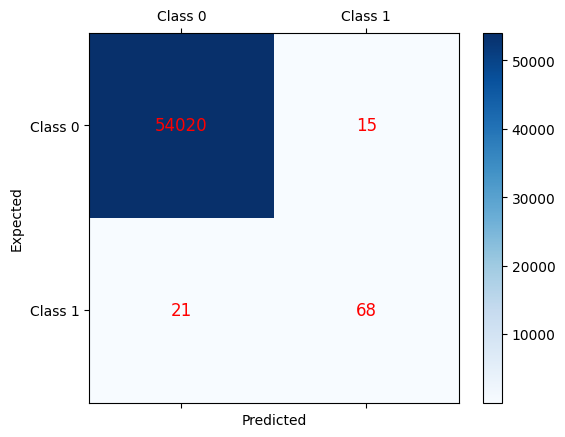

In [68]:
# Returns confusion matrix: predicted classes are in columns, they are ordered by class label ascending, as in “labels”.
# Meaning 0 1 in columns. Rows also 0 then 1.
print(metrics.confusionMatrix())

confusion_matrix = metrics.confusionMatrix().toArray()
labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix, cmap=plt.cm.Blues)
# Add actual values to the cells
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, str(int(confusion_matrix[i, j])), fontsize=12, ha='center', va='center', color='red')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()


In [69]:
# Traditional way to evaluate TN/TP/FP/FN
# Countercheck with confusion matrix above.
tn = prediction.filter((F.col('label')==0)&(F.col('prediction')==0)).count()
tp = prediction.filter((F.col('label')==1)&(F.col('prediction')==1)).count()
fp = prediction.filter((F.col('label')==0)&(F.col('prediction')==1)).count()
fn = prediction.filter((F.col('label')==1)&(F.col('prediction')==0)).count()

# print(f"TN: {tn}")
# print(f"TP: {tp}")
# print(f"FP: {fp}")
# print(f"FN: {fn}")

In [70]:
resultsTable.add_row(["Baseline" ,auroc, recall_o, accuracy_o, tn,tp,fp,fn]) 

### Undersampling Majority

In [71]:
# Create undersampling function
def undersample_majority(df, ratio=1):
    '''
    ratio is the ratio of majority to minority
    Eg. ratio 1 is equivalent to majority:minority = 1:1
    ratio 5 is equivalent to majority:minority = 5:1
    '''
    minority_count = df.filter(F.col('class')==1).count()
    whole_count = df.count()
    undersampled_majority = df.filter(F.col('class')==0)\
                                .sample(withReplacement=False, fraction=(ratio*minority_count/whole_count),seed=88)
    undersampled_df = df.filter(F.col('class')==1).union(undersampled_majority)
    
    return undersampled_df

In [72]:
# Create evaluation function
def evaluate_test_data(test_df, model, description):
    model_df = preprocess_data(test_df)
    prediction = model.transform(model_df)
    
    # Evaluate the model using a BinaryClassificationEvaluator
    evaluator = BinaryClassificationEvaluator(labelCol='label')
    auroc = evaluator.evaluate(prediction,{evaluator.metricName:'areaUnderROC'})
    aupr = evaluator.evaluate(prediction,{evaluator.metricName:'areaUnderPR'})

    # print(f"AUROC: {auroc}")
    # print(f"AUPR: {aupr}")
    
    # Evaluate using MultiClass Metrics
    pred_rdd = prediction.select('prediction','label').rdd.map(tuple)
    metrics = MulticlassMetrics(pred_rdd)
    accuracy_o = metrics.accuracy   # Positive class
    precision_o = metrics.precision(1.0)  # Positive class
    recall_o = metrics.recall(1.0)  # Positive class
    f1_o = metrics.fMeasure(1.0)  # Positive class

    # print("Accuracy:", accuracy_o)
    # print("Precision:", precision_o)
    # print("Recall:", recall_o)
    # print("F1-score:", f1_o)
    
    confusion_matrix = metrics.confusionMatrix().toArray()
    labels = ['Class 0', 'Class 1']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion_matrix, cmap=plt.cm.Blues)
    # Add actual values to the cells
    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, str(int(confusion_matrix[i, j])), fontsize=12, ha='center', va='center', color='red')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()

    # Traditional way to evaluate TN/TP/FP/FN
    # Countercheck with confusion matrix above.
    tn = prediction.filter((F.col('label')==0)&(F.col('prediction')==0)).count()
    tp = prediction.filter((F.col('label')==1)&(F.col('prediction')==1)).count()
    fp = prediction.filter((F.col('label')==0)&(F.col('prediction')==1)).count()
    fn = prediction.filter((F.col('label')==1)&(F.col('prediction')==0)).count()

    # print(f"TN: {tn}")
    # print(f"TP: {tp}")
    # print(f"FP: {fp}")
    # print(f"FN: {fn}")
    
    resultsTable.add_row([description ,auroc, recall_o, accuracy_o, tn,tp,fp,fn]) 


c:\Users\mcmar\Downloads\.conda\Lib\site-packages\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
C:\Users\mcmar\AppData\Local\Temp\ipykernel_31200\3716567219.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels)
C:\Users\mcmar\AppData\Local\Temp\ipykernel_31200\3716567219.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


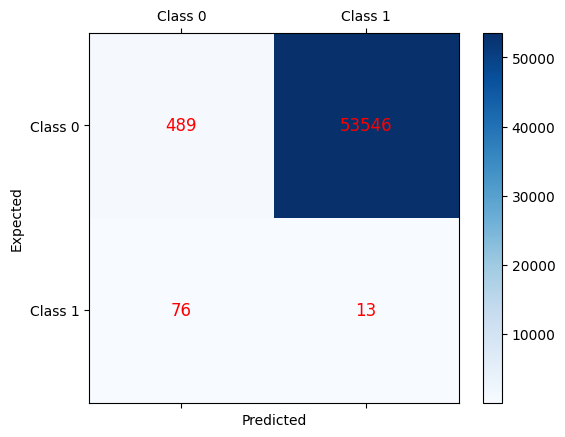

In [73]:
# Evaluate Undersampling 1:1
undersampled_train_df_1_1 = undersample_majority(train_data,1)
rf_model1 = train_model(undersampled_train_df_1_1)
evaluate_test_data(test_data, rf_model1,"Undersampling 1:1")

c:\Users\mcmar\Downloads\.conda\Lib\site-packages\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
C:\Users\mcmar\AppData\Local\Temp\ipykernel_31200\3716567219.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels)
C:\Users\mcmar\AppData\Local\Temp\ipykernel_31200\3716567219.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


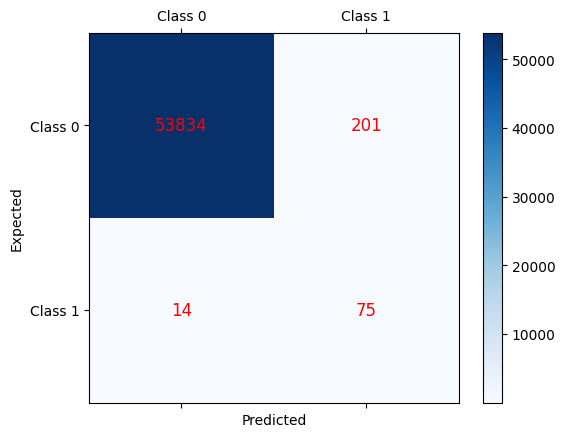

In [74]:
# Evaluate Undersampling 1:2
undersampled_train_df_1_2 = undersample_majority(train_data,2)
rf_model2 = train_model(undersampled_train_df_1_2)
evaluate_test_data(test_data, rf_model2,"Undersampling 1:2")

c:\Users\mcmar\Downloads\.conda\Lib\site-packages\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
C:\Users\mcmar\AppData\Local\Temp\ipykernel_31200\3716567219.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels)
C:\Users\mcmar\AppData\Local\Temp\ipykernel_31200\3716567219.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


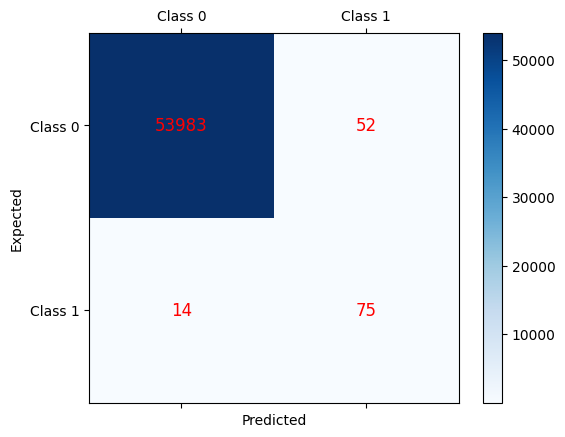

In [75]:
# Evaluate Undersampling 1:5
undersampled_train_df_1_5 = undersample_majority(train_data,5)
rf_model3 = train_model(undersampled_train_df_1_5)
evaluate_test_data(test_data, rf_model3,"Undersampling 1:5")

### Oversampling Minority

In [76]:
# Create undersampling function
def oversample_minority(df, ratio=1):
    '''
    ratio is the ratio of majority to minority
    Eg. ratio 1 is equivalent to majority:minority = 1:1
    ratio 5 is equivalent to majority:minority = 5:1
    '''
    minority_count = df.filter(F.col('class')==1).count()
    majority_count = df.filter(F.col('class')==0).count()
    
    balance_ratio = majority_count / minority_count
    
    print(f"Initial Majority:Minority ratio is {balance_ratio:.2f}:1")
    if ratio >= balance_ratio:
        print("No oversampling of minority was done as the input ratio was more than or equal to the initial ratio.")
    else:
        print(f"Oversampling of minority done such that Majority:Minority ratio is {ratio}:1")
    
    oversampled_minority = df.filter(F.col('class')==1)\
                                .sample(withReplacement=True, fraction=(balance_ratio/ratio),seed=88)
    oversampled_df = df.filter(F.col('class')==0).union(oversampled_minority)
    
    return oversampled_df

Initial Majority:Minority ratio is 574.62:1
Oversampling of minority done such that Majority:Minority ratio is 1:1


c:\Users\mcmar\Downloads\.conda\Lib\site-packages\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
C:\Users\mcmar\AppData\Local\Temp\ipykernel_31200\3716567219.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels)
C:\Users\mcmar\AppData\Local\Temp\ipykernel_31200\3716567219.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


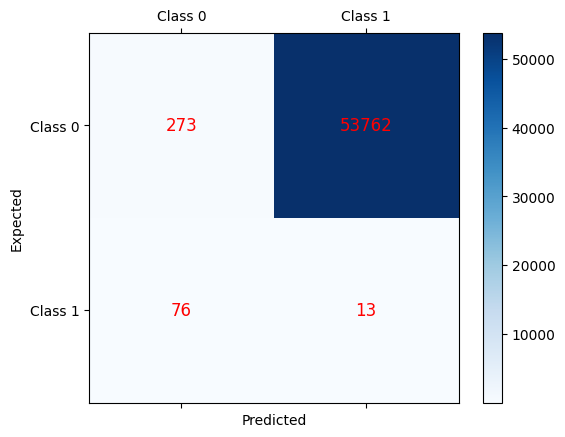

In [77]:
# Train 3 different oversamplings
# Evaluate Oversampling 1:1
oversampled_train_df_1_1 = oversample_minority(train_data,1)
rf_model4 = train_model(oversampled_train_df_1_1)
evaluate_test_data(test_data, rf_model4,"Oversampling 1:1")

Initial Majority:Minority ratio is 574.62:1
Oversampling of minority done such that Majority:Minority ratio is 2:1


c:\Users\mcmar\Downloads\.conda\Lib\site-packages\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
C:\Users\mcmar\AppData\Local\Temp\ipykernel_31200\3716567219.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels)
C:\Users\mcmar\AppData\Local\Temp\ipykernel_31200\3716567219.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


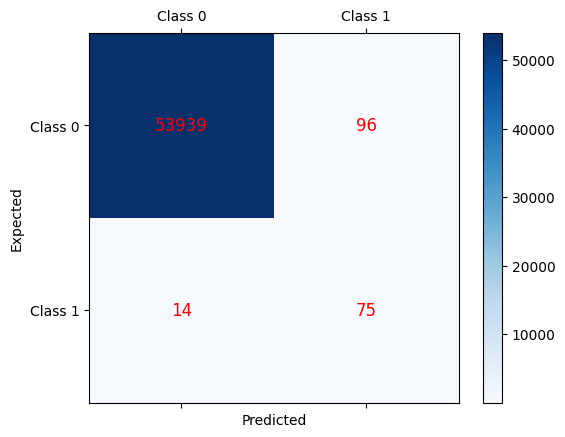

In [78]:
# Evaluate Oversampling 1:2
oversampled_train_df_1_2 = oversample_minority(train_data,2)
rf_model5 = train_model(oversampled_train_df_1_2)
evaluate_test_data(test_data, rf_model5,"Oversampling 1:2")

Initial Majority:Minority ratio is 574.62:1
Oversampling of minority done such that Majority:Minority ratio is 5:1


c:\Users\mcmar\Downloads\.conda\Lib\site-packages\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
C:\Users\mcmar\AppData\Local\Temp\ipykernel_31200\3716567219.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels)
C:\Users\mcmar\AppData\Local\Temp\ipykernel_31200\3716567219.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


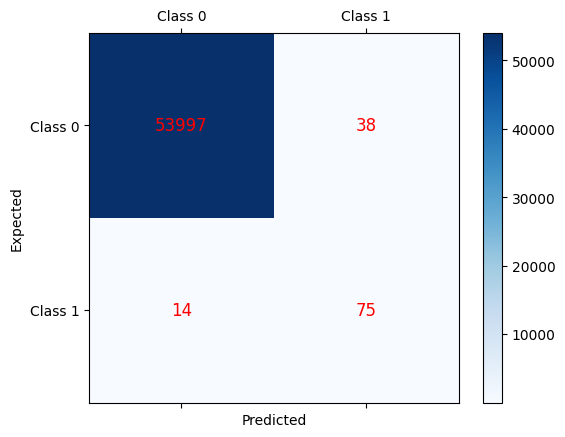

In [79]:
# Evaluate Oversampling 1:5
oversampled_train_df_1_5 = oversample_minority(train_data,5)
rf_model6 = train_model(oversampled_train_df_1_5)
evaluate_test_data(test_data, rf_model6,"Oversampling 1:5")

### Oversampling using SMOTE  

In [80]:


import random
import numpy as np
from functools import reduce
from pyspark.sql import DataFrame, SparkSession, Row
import pyspark.sql.functions as F
from pyspark.sql.functions import array, create_map, struct, rand,col,when,concat,substring,lit,udf,lower,sum as ps_sum,count as ps_count,row_number
from pyspark.sql.window import *
from pyspark.sql.window import Window
from pyspark.sql.types import StructField, StructType, StringType, IntegerType, LongType
from pyspark.ml.feature import VectorAssembler,BucketedRandomProjectionLSH,VectorSlicer,StringIndexer
from pyspark.ml.linalg import Vectors, VectorUDT, SparseVector, DenseVector
from pyspark.ml import Pipeline

def pre_smote_df_process(df,num_cols,cat_cols,target_col,index_suffix="_index"):
    '''
    string indexer and vector assembler
    inputs:
    * df: spark df, original
    * num_cols: numerical cols to be assembled
    * cat_cols: categorical cols to be stringindexed
    * target_col: prediction target
    * index_suffix: will be the suffix after string indexing
    output:
    * vectorized: spark df, after stringindex and vector assemble, ready for smote
    '''
    if(df.select(target_col).distinct().count() != 2):
         raise ValueError("Target col must have exactly 2 classes")
        
    if target_col in num_cols:
        num_cols.remove(target_col)

    # only assembled numeric columns into features
    assembler = VectorAssembler(inputCols = num_cols, outputCol = 'features_for_model')
    # index the string cols, except possibly for the label col
    assemble_stages = [StringIndexer(inputCol=column, outputCol=column+index_suffix) for column in list(set(cat_cols)-set([target_col]))]
    # add the stage of numerical vector assembler
    assemble_stages.append(assembler)
    pipeline = Pipeline(stages=assemble_stages)
    pos_vectorized = pipeline.fit(df).transform(df)
    
    # drop original num cols and cat cols
    drop_cols = num_cols+cat_cols
    
    keep_cols = [a for a in pos_vectorized.columns if a not in drop_cols]
    
    vectorized = pos_vectorized.select(*keep_cols).withColumn('label',pos_vectorized[target_col]).drop(target_col)
    
    return vectorized

def subtract_vector_fn(arr):
    a = arr[0]
    b = arr[1]
    
    if isinstance(a, SparseVector):
        a = a.toArray()
        
    if isinstance(b, SparseVector):
        b = b.toArray()
    
    return DenseVector(random.uniform(0, 1)*(a-b))
    
def add_vector_fn(arr):
    a = arr[0]
    b = arr[1]
    
    if isinstance(a, SparseVector):
        a = a.toArray()
        
    if isinstance(b, SparseVector):
        b = b.toArray()
    
    return DenseVector(a+b)

def smote(vectorized_sdf,smote_config):
    '''
    contains logic to perform smote oversampling, given a spark df with 2 classes
    inputs:
    * vectorized_sdf: cat cols are already stringindexed, num cols are assembled into 'features' vector
      df target col should be 'label'
    * smote_config: config obj containing smote parameters
    output:
    * oversampled_df: spark df after smote oversampling
    '''
    dataInput_min = vectorized_sdf[vectorized_sdf['label'] == smote_config.positive_label]
    dataInput_maj = vectorized_sdf[vectorized_sdf['label'] == smote_config.negative_label]
    
    # LSH, bucketed random projection
    brp = BucketedRandomProjectionLSH(inputCol="features_for_model", outputCol="hashes",seed=int(smote_config.seed),\
                                      bucketLength=float(smote_config.bucketLength))
    # smote only applies on existing minority instances    
    model = brp.fit(dataInput_min)
    model.transform(dataInput_min)

    # here distance is calculated from brp's param inputCol
    self_join_w_distance = model.approxSimilarityJoin(dataInput_min, dataInput_min, float('inf'), distCol="EuclideanDistance")

    # remove self-comparison (distance 0)
    self_join_w_distance = self_join_w_distance.filter(self_join_w_distance.EuclideanDistance > 0)

    over_original_rows = Window.partitionBy("datasetA").orderBy("EuclideanDistance")

    self_similarity_df = self_join_w_distance.withColumn("r_num", F.row_number().over(over_original_rows))

    self_similarity_df_selected = self_similarity_df.filter(self_similarity_df.r_num <= int(smote_config.k))

    over_original_rows_no_order = Window.partitionBy('datasetA')

    # list to store batches of synthetic data
    res = []
    
    # two udf for vector add and subtract, subtraction include a random factor [0,1]
    subtract_vector_udf = F.udf(subtract_vector_fn, VectorUDT())
    add_vector_udf = F.udf(add_vector_fn, VectorUDT())
    
    # retain original columns
    original_cols = dataInput_min.columns
    
    for i in range(int(smote_config.multiplier)):
        # print("generating batch %s of synthetic instances"%i)
        # logic to randomly select neighbour: pick the largest random number generated row as the neighbour
        df_random_sel = self_similarity_df_selected\
                            .withColumn("rand", F.rand())\
                            .withColumn('max_rand', F.max('rand').over(over_original_rows_no_order))\
                            .where(F.col('rand') == F.col('max_rand')).drop(*['max_rand','rand','r_num'])
        # create synthetic feature numerical part
        df_vec_diff = df_random_sel\
            .select('*', subtract_vector_udf(F.array('datasetA.features_for_model', 'datasetB.features_for_model')).alias('vec_diff'))
        df_vec_modified = df_vec_diff\
            .select('*', add_vector_udf(F.array('datasetB.features_for_model', 'vec_diff')).alias('features_for_model'))
        
        # for categorical cols, either pick original or the neighbour's cat values
        for c in original_cols:
            # randomly select neighbour or original data
            col_sub = random.choice(['datasetA','datasetB'])
            val = "{0}.{1}".format(col_sub,c)
            if c != 'features_for_model':
                # do not unpack original numerical features
                df_vec_modified = df_vec_modified.withColumn(c,F.col(val))
        
        # this df_vec_modified is the synthetic minority instances,
        df_vec_modified = df_vec_modified.drop(*['datasetA','datasetB','vec_diff','EuclideanDistance'])
        
        res.append(df_vec_modified)
    
    dfunion = reduce(DataFrame.union, res)
    dfunion = dfunion.union(dataInput_min.select(dfunion.columns))\
        .sort(F.rand(seed=smote_config.seed))\
        .withColumn('row_number', row_number().over(Window.orderBy(lit('A'))))
    
    dataInput_maj = dataInput_maj.withColumn('row_number', row_number().over(Window.orderBy(lit('A'))))
    
    # union synthetic instances with original full (both minority and majority) df
    oversampled_df = dfunion.union(dataInput_maj.select(dfunion.columns))
    
    return oversampled_df.sort('row_number').drop(*['row_number'])

class SmoteConfig:
    def __init__(self, seed, bucketLength, k, multiplier, positive_label, negative_label):
        self.seed = seed
        self.bucketLength = bucketLength
        self.k = k
        self.multiplier = multiplier
        self.positive_label = positive_label
        self.negative_label = negative_label

In [81]:
def wrapper_smote(config_file):
    feature_list = ['V1', 'V2', 'V3', 'V4' ,'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',  'Amount']
    smote_df = pre_smote_df_process(train_data,feature_list,[],'Class',index_suffix="_index")
    train_smoted_df = smote(smote_df, config_file)
    
    rf_model_smote = train_model(train_smoted_df,smote=1)
    return rf_model_smote

c:\Users\mcmar\Downloads\.conda\Lib\site-packages\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
C:\Users\mcmar\AppData\Local\Temp\ipykernel_31200\3716567219.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels)
C:\Users\mcmar\AppData\Local\Temp\ipykernel_31200\3716567219.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


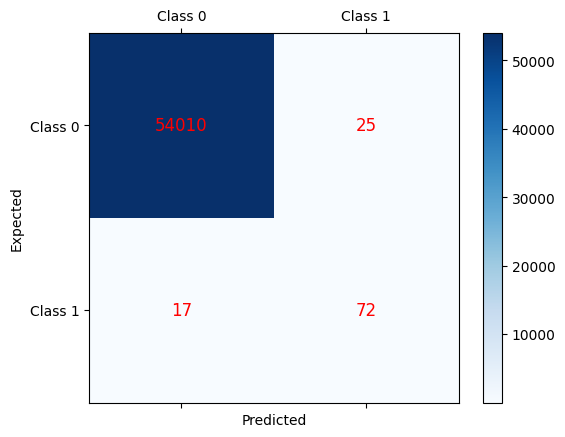

In [82]:
# Config k = 10, Multiplier = 25
config4a = SmoteConfig(76, 200, 10, 25, 1, 0)
rf_model10a = wrapper_smote(config4a)
evaluate_test_data(test_data, rf_model10a, "SMOTE 76, 200, 10, 25")

c:\Users\mcmar\Downloads\.conda\Lib\site-packages\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
C:\Users\mcmar\AppData\Local\Temp\ipykernel_31200\3716567219.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels)
C:\Users\mcmar\AppData\Local\Temp\ipykernel_31200\3716567219.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


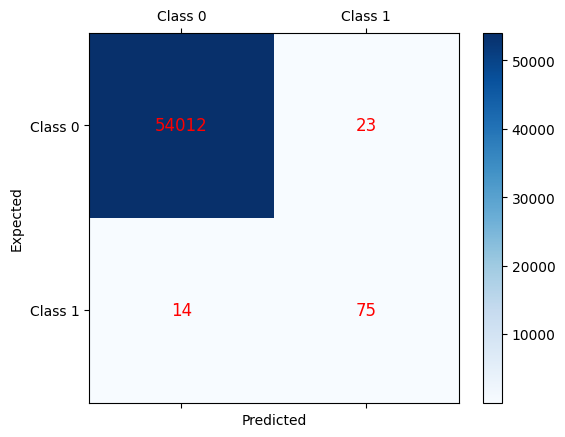

In [83]:
# Config k = 5, Multiplier = 25
config4a = SmoteConfig(76, 20, 5, 25, 1, 0)
rf_model10a = wrapper_smote(config4a)
evaluate_test_data(test_data, rf_model10a, "SMOTE 76, 20, 5, 25")

c:\Users\mcmar\Downloads\.conda\Lib\site-packages\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
C:\Users\mcmar\AppData\Local\Temp\ipykernel_31200\3716567219.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + labels)
C:\Users\mcmar\AppData\Local\Temp\ipykernel_31200\3716567219.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + labels)


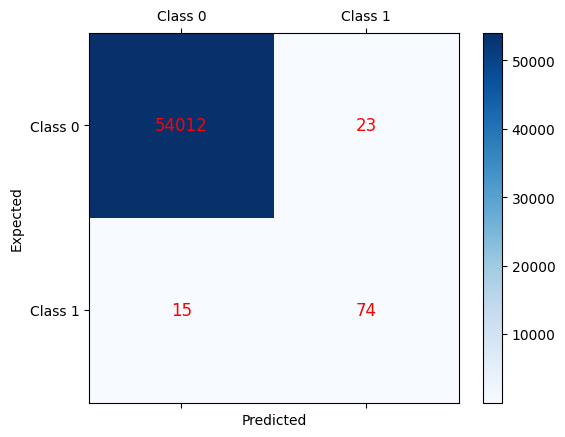

In [84]:
# Config k = 5, Multiplier = 25
config4a = SmoteConfig(76, 1, 5, 25, 1, 0)
rf_model10a = wrapper_smote(config4a)
evaluate_test_data(test_data, rf_model10a,"SMOTE 76, 1, 5, 25")

In [85]:
print(resultsTable )

+-----------------------+----------------------+---------------------+----------------------+-------+----+-------+----+
|         Method        |        AUROC         |        Recall       |       Accuracy       |   TN  | TP |   FP  | FN |
+-----------------------+----------------------+---------------------+----------------------+-------+----+-------+----+
|        Baseline       |  0.9529235628592787  |  0.7640449438202247 |  0.9993348606902668  | 54020 | 68 |   15  | 21 |
|   Undersampling 1:1   | 0.024630415367484466 | 0.14606741573033707 | 0.009274998152390806 |  489  | 13 | 53546 | 76 |
|   Undersampling 1:2   |  0.9768822330096077  |  0.8426966292134831 |  0.9960276402335378  | 53834 | 75 |  201  | 14 |
|   Undersampling 1:5   |  0.954200305045731   |  0.8426966292134831 |  0.9987805779321558  | 53983 | 75 |   52  | 14 |
|    Oversampling 1:1   | 0.03041900640762386  | 0.14606741573033707 | 0.005284162293991575 |  273  | 13 | 53762 | 76 |
|    Oversampling 1:2   |  0.95485271198

The undersampling 1:1 performed really poorly with a very low AUROC / Recall / Accuracy. 

The undersampling 2:1 ( rf_model2) performed the best with the highest AUROC of 0.977, and a significantly high recall of 0.843.

